In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.65_.9',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_saw')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.65_.9',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_saw')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 257.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.5, .65, .9/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 5e-25

include 'saw75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

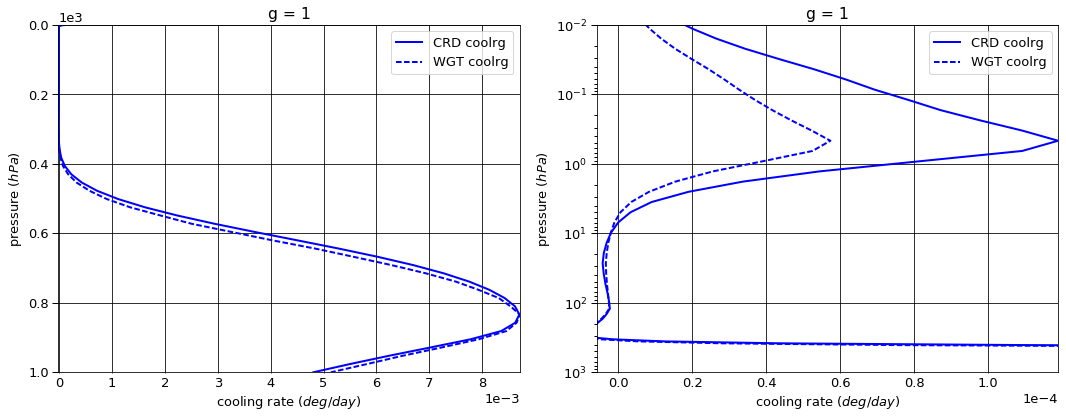

# Figure: cooling rate g-group 2

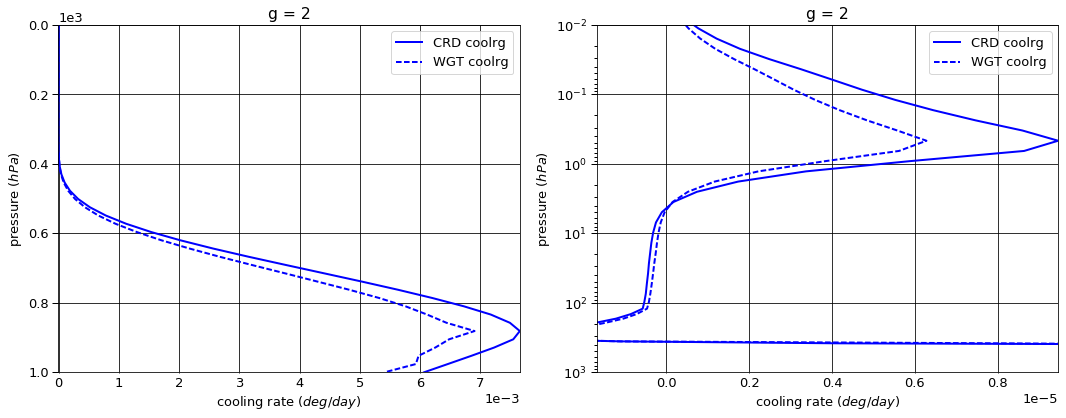

# Figure: cooling rate g-group 3

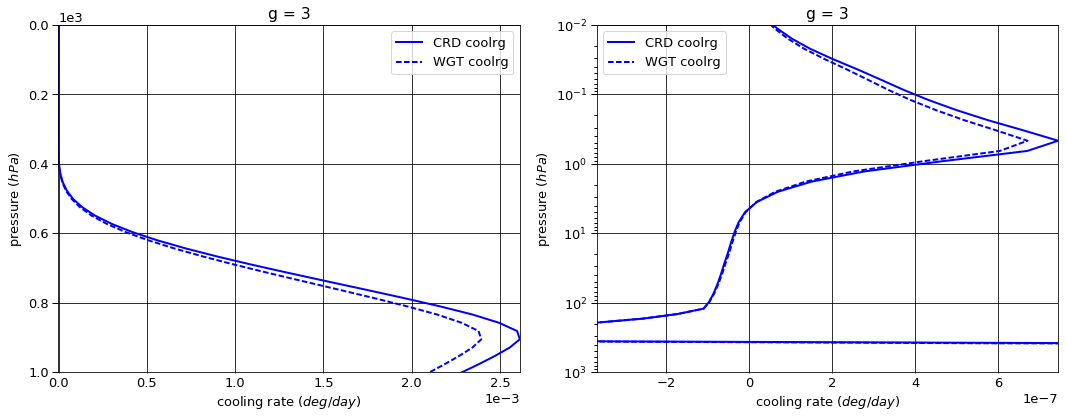

# Figure: cooling rate g-group total

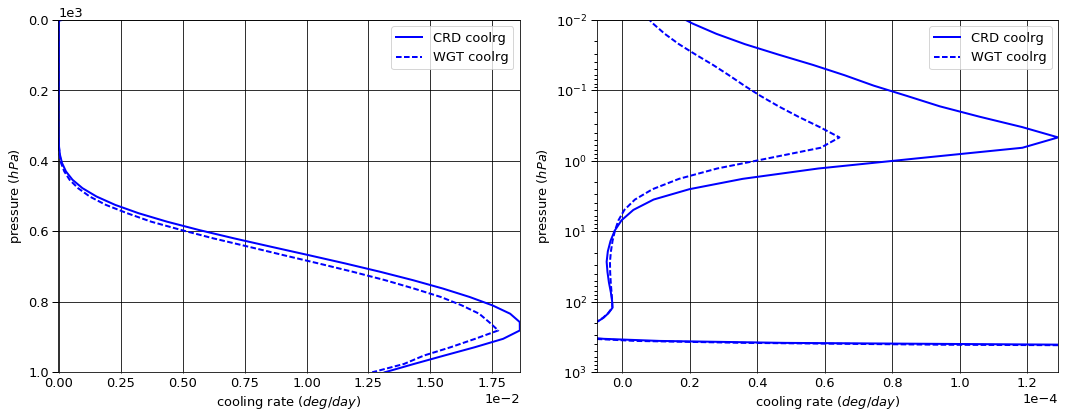

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.877527  0.000000  -0.877527
  1013.0   76     -0.904930  0.401481  -0.503448
2 0.0      1      -4.333343  0.000000  -4.333343
  1013.0   76     -4.342285  0.292253  -4.050032
3 0.0      1     -27.614407  0.000000 -27.614407
  1013.0   76    -27.616552  0.094933 -27.521619


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.881413  0.000000  -0.881413
  1013.0   76     -0.904930  0.387942  -0.516988
2 0.0      1      -4.334805  0.000000  -4.334805
  1013.0   76     -4.342285  0.252826  -4.089459
3 0.0      1     -27.614560  0.000000 -27.614560
  1013.0   76    -27.616552  0.086867 -27.529684


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.003886  0.000000 -0.003886
  1013.0   76     0.000000 -0.013539 -0.013539
2 0.0      1     -0.001463  0.000000 -0.001463
  1013.0   76     0.000000 -0.039427 -0.039427
3 0.0      1     -0.000153  0.000000 -0.000153
  1013.0   76     0.000000 -0.008065 -0.008065

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.189107e-06
  1001.112500 75     4.806915e-03
2 0.000312    1     -4.058515e-07
  1001.112500 75     6.064071e-03
3 0.000312    1     -4.082772e-08
  1001.112500 75     2.284237e-03


WGT


coolrg
g pressure    layer              
1 0.000312    1     -3.432817e-06
  1001.112500 75     5.138401e-03
2 0.000312    1     -2.273864e-07
  1001.112500 75     5.410162e-03
3 0.000312    1     -3.549610e-08
  1001.112500 75     2.100842e-03


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.756290e-06
  1001.112500 75     3.314859e-04
2 0.000312    1      1.784652e-07
  1001.112500 75    -6.539093e-04
3 0.000312    1      5.331620e-09
  1001.112500 75    -1.833949e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.825277,0.000000,-32.825277
1013.0,76,-32.863767,0.788667,-32.075099



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.830778,0.000000,-32.830778
1013.0,76,-32.863767,0.727635,-32.136131



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.005502,0.000000,-0.005502
1013.0,76,0.000000,-0.061032,-0.061032


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.013155



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000004
1001.112500,75,0.012649



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,-0.000506


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.025750,0.027658
2,0.128833,0.132364
3,0.845417,0.839979


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,8.423988e-24
2,5.000223e-25
3,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,8.423988e-24,NaN,0.025750,0.027658,0.025750,0.027658,600.0
2,5.000223e-25,0.059357,0.128833,0.132364,0.154583,0.160021,600.0
3,2.367330e-27,0.004734,0.845417,0.839979,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog       ratio
layer g                                                     
1     1     0.000312  1.335587e-23  3.475995e-25   38.423166
      2     0.000312  1.127147e-25  5.235708e-27   21.528068
      3     0.000312  1.961617e-27  2.348467e-29   83.527555
2     1     0.000750  1.389204e-23  3.515857e-25   39.512540
      2     0.000750  1.200912e-25  5.328108e-27   22.539186
      3     0.000750  2.059696e-27  2.404728e-29   85.651968
3     1     0.001052  1.504366e-23  3.593472e-25   41.863859
      2     0.001052  1.365157e-25  5.518983e-27   24.735671
      3     0.001052  2.274054e-27  2.517454e-29   90.331470
4     1     0.001476  1.630967e-23  3.669827e-25   44.442598
      2     0.001476  1.554592e-25  5.722618e-27   27.165747
      3     0.001476  2.515550e-27  2.637709e-29   95.368753
5     1     0.002070  1.768424e-23  3.743694e-25   47.237410
      2     0.002070  1.770399e-25  5.938576e-27   29.811852
      3     0.002070  2.784649e-27  2.765117e-29  100.706380
6     1     0.002904  1.917605e-23  3.814861e-25   50.266709
      2     0.002904  2.016081e-25  6.167816e-27   32.687119
      3     0.002904  3.084781e-27  2.901017e-29  106.334490
7     1     0.004074  2.079439e-23  3.883339e-25   53.547692
      2     0.004074  2.295568e-25  6.410482e-27   35.809605
      3     0.004074  3.419864e-27  3.047304e-29  112.225870
8     1     0.005714  2.254949e-23  3.949570e-25   57.093541
      2     0.005714  2.613315e-25  6.666340e-27   39.201641
      3     0.005714  3.794430e-27  3.206711e-29  118.327780
9     1     0.008015  2.445185e-23  4.014610e-25   60.907161
      2     0.008015  2.974219e-25  6.935265e-27   42.885435
      3     0.008015  4.213561e-27  3.383160e-29  124.545130
10    1     0.011243  2.651318e-23  4.080395e-25   64.976987
      2     0.011243  3.383846e-25  7.218140e-27   46.879755
      3     0.011243  4.683194e-27  3.582540e-29  130.722720
11    1     0.015771  2.874559e-23  4.149932e-25   69.267617
      2     0.015771  3.848328e-25  7.517643e-27   51.190618
      3     0.015771  5.210055e-27  3.813771e-29  136.611640
12    1     0.022122  3.116194e-23  4.227571e-25   73.711218
      2     0.022122  4.374464e-25  7.839353e-27   55.801332
      3     0.022122  5.801857e-27  4.090536e-29  141.836110
13    1     0.031031  3.376377e-23  4.319100e-25   78.173160
      2     0.031031  4.966973e-25  8.191769e-27   60.633704
      3     0.031031  6.464339e-27  4.432852e-29  145.827990
14    1     0.043528  3.623755e-23  4.425997e-25   81.874329
      2     0.043528  5.554245e-25  8.556691e-27   64.911133
      3     0.043528  7.119054e-27  4.847163e-29  146.870530
15    1     0.061057  3.826201e-23  4.551048e-25   84.072967
      2     0.061057  6.051520e-25  8.923701e-27   67.814018
      3     0.061057  7.673888e-27  5.345208e-29  143.565770
16    1     0.085645  4.009359e-23  4.710747e-25   85.110909
      2     0.085645  6.513888e-25  9.346983e-27   69.689745
      3     0.085645  8.191508e-27  5.991301e-29  136.723360
17    1     0.120136  4.199756e-23  4.926554e-25   85.247347
      2     0.120136  7.006680e-25  9.890922e-27   70.839497
      3     0.120136  8.745739e-27  6.874107e-29  127.227290
18    1     0.168516  4.398328e-23  5.220029e-25   84.258704
      2     0.168516  7.533389e-25  1.060796e-26   71.016407
      3     0.168516  9.342330e-27  8.090771e-29  115.468960
19    1     0.236378  4.605146e-23  5.618878e-25   81.958467
      2     0.236378  8.095321e-25  1.156846e-26   69.977524
      3     0.236378  9.985385e-27  9.775859e-29  102.143300
20    1     0.331549  4.820092e-23  6.157738e-25   78.276996
      2     0.331549  8.693182e-25  1.286563e-26   67.569029
      3     0.331549  1.067947e-26  1.211386e-28   88.159059
21    1     0.465100  5.019605e-23  6.867698e-25   73.090058
      2     0.465100  9.259979e-25  1.457951e-26   63.513642
      3     0.465100  1.135422e-26  1.529952e-28   74.212903
22    1     0.652400  4.852545e-23  7.585319e-2

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
